# Gesture Recognition using Transformer Encoder

The **Transformer Encoder** applies **self-attention** mechanisms to learn from long-range temporal dependencies in skeleton data. It treats gesture sequences as a form of structured **time series** and focuses on relationships between frames rather than joint locations. While it doesn’t inherently capture spatial structure, its flexibility and attention weighting allow it to generalize well to subtle or slower gestures.

This project supports gesture-based communication between humans and robots in real-world environments like retail, manufacturing, or healthcare where hands-free interaction is more effective.

In [ ]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split


In [ ]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class SkeletonTransformerDataset(Dataset):
    def __init__(self, metadata, data_dir, target_frames=50):
        self.file_names = list(metadata.keys())
        self.labels = [metadata[f] for f in self.file_names]
        self.data_dir = data_dir
        self.target_frames = target_frames

    def __len__(self):
        return len(self.file_names)

    def center_skeleton(self, skel):
        center = skel[:, 0:1, :]
        return skel - center

    def normalize_skeleton(self, skel):
        max_val = np.max(np.abs(skel))
        return skel / (max_val + 1e-5)

    def sample_frames(self, skel):
        n_frames = skel.shape[0]
        if n_frames == self.target_frames:
            return skel
        elif n_frames > self.target_frames:
            idx = np.linspace(0, n_frames - 1, self.target_frames).astype(int)
            return skel[idx]
        else:
            pad = np.repeat(skel[-1:], self.target_frames - n_frames, axis=0)
            return np.concatenate([skel, pad], axis=0)


    def __getitem__(self, idx):
        file = self.file_names[idx]
        label = self.labels[idx]
        skeleton = np.load(os.path.join(self.data_dir, file), allow_pickle=True).item()['skel_body0']  # Access skel_body0 directly

        # Check if skeleton is a single frame and reshape if necessary
        if skeleton.ndim == 2:  # Single frame
            skeleton = skeleton[np.newaxis, ...]  # Add a dimension for time

        skeleton = self.center_skeleton(skeleton)
        skeleton = self.normalize_skeleton(skeleton)
        skeleton = self.sample_frames(skeleton)

        # Check dimensions and transpose if necessary
        if skeleton.ndim == 3 and skeleton.shape[0] != skeleton.shape[1]:
            skeleton = np.transpose(skeleton, (1, 2, 0))  # (T, V, C)

        # Reshape to (T, features)
        frame_seq = skeleton.reshape(skeleton.shape[0], -1)  # (T, V*C)

        return torch.tensor(frame_seq, dtype=torch.float32), label

In [ ]:
dataset = SkeletonTransformerDataset(metadata, data_dir="/content/gesture_data/parsed_data")


In [ ]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 39604, Val: 8486, Test: 8488


In [ ]:
batch_size = 128  # Rishi: You can change batch_size below and continue from here with model training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
import torch.nn as nn
import torch.optim as optim


Defining the Transformer Model

In [ ]:
class GestureTransformer(nn.Module):
    def __init__(self, input_dim=150, seq_len=300, num_classes=60, #Changed the input_dim from 75 to 150
                 d_model=128, nhead=4, num_layers=2, dropout=0.2):
        super(GestureTransformer, self).__init__()

        self.input_proj = nn.Linear(input_dim, d_model) #input_dim is now 150
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x shape: (batch, seq_len, input_dim)
        x = self.input_proj(x) + self.pos_embedding[:, :x.size(1), :]
        x = self.transformer(x)  # (batch, seq_len, d_model)
        x = x.permute(0, 2, 1)   # for pooling: (batch, d_model, seq_len)
        x = self.pool(x).squeeze(-1)  # (batch, d_model)
        return self.fc(x)  # (batch, num_classes)

Initializing the model, optimizer, and loss function

In [ ]:
#Rishi starts training on Google Collab Pro

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GestureTransformer().to(device)
#optimizer = optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()


Simple Training Loop

In [ ]:
# *OPTIONAL* TUNING IDEAS FOR RISHI:
# Try increasing d_model from 128 to 256 if memory allows
# Try more layers: num_layers = 3 (currently 2)
# Add dropout=0.2 if overfitting starts early
# Increase batch_size to 128 if GPU can handle it
# Reduce seq_len if memory errors (use only first 150 frames)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=3,
    factor=0.5,
    verbose=True
)

# Training Function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = output.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / len(loader), correct / total




/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validation Loop

In [ ]:
# Evaluation Function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item()
            preds = output.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return total_loss / len(loader), correct / total


Train for a Few Epochs

In [ ]:
num_epochs = 60

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}\n")

    # Update learning rate based on validation loss
    scheduler.step(val_loss)


Epoch 1/60
Train Loss: 3.7614, Accuracy: 0.0593
Val Loss: 3.3885, Accuracy: 0.1059

Epoch 2/60
Train Loss: 3.1947, Accuracy: 0.1518
Val Loss: 2.9502, Accuracy: 0.1937

Epoch 3/60
Train Loss: 2.8575, Accuracy: 0.2236
Val Loss: 2.7109, Accuracy: 0.2524

Epoch 4/60
Train Loss: 2.6386, Accuracy: 0.2728
Val Loss: 2.5260, Accuracy: 0.2884

Epoch 5/60
Train Loss: 2.4822, Accuracy: 0.3083
Val Loss: 2.4223, Accuracy: 0.3159

Epoch 6/60
Train Loss: 2.3646, Accuracy: 0.3338
Val Loss: 2.2902, Accuracy: 0.3437

Epoch 7/60
Train Loss: 2.2539, Accuracy: 0.3619
Val Loss: 2.1757, Accuracy: 0.3771

Epoch 8/60
Train Loss: 2.1535, Accuracy: 0.3886
Val Loss: 2.0979, Accuracy: 0.3963

Epoch 9/60
Train Loss: 2.0718, Accuracy: 0.4090
Val Loss: 2.0085, Accuracy: 0.4236

Epoch 10/60
Train Loss: 1.9932, Accuracy: 0.4259
Val Loss: 1.9328, Accuracy: 0.4431

Epoch 11/60
Train Loss: 1.9331, Accuracy: 0.4431
Val Loss: 1.9217, Accuracy: 0.4362

Epoch 12/60
Train Loss: 1.8739, Accuracy: 0.4574
Val Loss: 1.8667, Accurac

Classification Report:
              precision    recall  f1-score   support

           0     0.5547    0.5802    0.5672       131
           1     0.6566    0.6606    0.6586       165
           2     0.5889    0.7361    0.6543       144
           3     0.6291    0.6934    0.6597       137
           4     0.6803    0.5971    0.6360       139
           5     0.7758    0.8828    0.8258       145
           6     0.7616    0.7986    0.7797       144
           7     0.9231    0.9296    0.9263       142
           8     0.9085    0.9281    0.9181       139
           9     0.6528    0.3219    0.4312       146
          10     0.5143    0.2449    0.3318       147
          11     0.4551    0.5033    0.4780       151
          12     0.6323    0.7313    0.6782       134
          13     0.9259    0.8929    0.9091       140
          14     0.8106    0.8106    0.8106       132
          15     0.5028    0.5987    0.5465       152
          16     0.5258    0.3750    0.4378       136
    

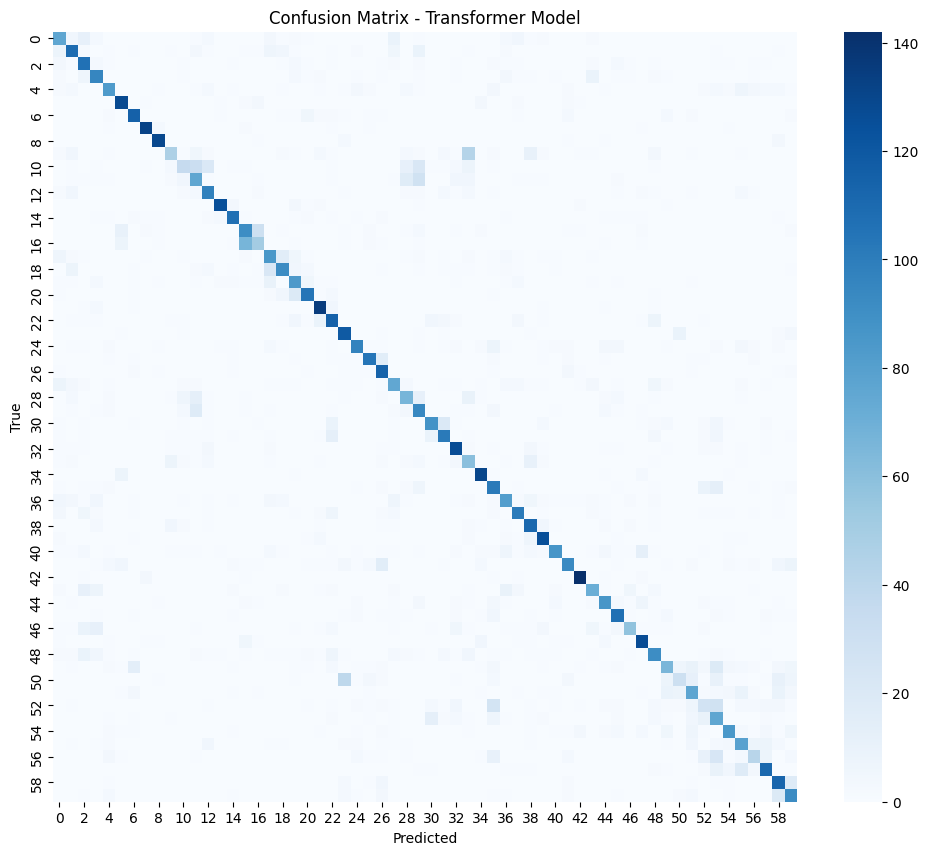

In [ ]:
#for the libraries

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


#inference on test data -
all_preds = []
all_labels = []
model.eval()

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        output = model(x)
        preds = output.argmax(dim=1).cpu().numpy()
        labels = y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)


#classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))




In [ ]:
import csv
import os

epochs=100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

best_val_acc = 0
patience = 10
patience_counter = 0

# --- Setup CSV logging ---
log_file_path = "Devansh_training_log.csv"
os.makedirs("logs", exist_ok=True)
log_file = open(log_file_path, mode='w', newline='')
log_writer = csv.writer(log_file)
log_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc", "Learning Rate"])

# --- Training loop ---
for epoch in range(epochs):
    # Pass optimizer and criterion to the train function
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Log to CSV per epoch
    log_writer.writerow([epoch+1, train_loss, val_loss, train_acc, val_acc, learning_rates[-1]])

    # Display
    print(f"📅 Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_ctr_model.pth")
        print("✅ Best model saved!")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("🛑 Early stopping: no improvement after", patience, "epochs.")
            break

# --- Finish ---
log_file.close()
print("🎉 Training complete!")

📅 Epoch 1/100 | Train Loss: 2.8694, Acc: 0.2175 | Val Loss: 2.7377, Acc: 0.2372
✅ Best model saved!
📅 Epoch 2/100 | Train Loss: 2.6787, Acc: 0.2569 | Val Loss: 2.5447, Acc: 0.2881
✅ Best model saved!
📅 Epoch 3/100 | Train Loss: 2.5330, Acc: 0.2936 | Val Loss: 2.4149, Acc: 0.3132
✅ Best model saved!
📅 Epoch 4/100 | Train Loss: 2.3822, Acc: 0.3303 | Val Loss: 2.2484, Acc: 0.3581
✅ Best model saved!
📅 Epoch 5/100 | Train Loss: 2.2555, Acc: 0.3639 | Val Loss: 2.1470, Acc: 0.3772
✅ Best model saved!
📅 Epoch 6/100 | Train Loss: 2.1435, Acc: 0.3895 | Val Loss: 2.0579, Acc: 0.4050
✅ Best model saved!
📅 Epoch 7/100 | Train Loss: 2.0638, Acc: 0.4072 | Val Loss: 2.0189, Acc: 0.4163
✅ Best model saved!
📅 Epoch 8/100 | Train Loss: 1.9971, Acc: 0.4257 | Val Loss: 1.9330, Acc: 0.4414
✅ Best model saved!
📅 Epoch 9/100 | Train Loss: 1.9406, Acc: 0.4380 | Val Loss: 1.8933, Acc: 0.4474
✅ Best model saved!
📅 Epoch 10/100 | Train Loss: 1.8945, Acc: 0.4503 | Val Loss: 1.8461, Acc: 0.4603
✅ Best model saved!

<ipython-input-41-652574dc6612>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


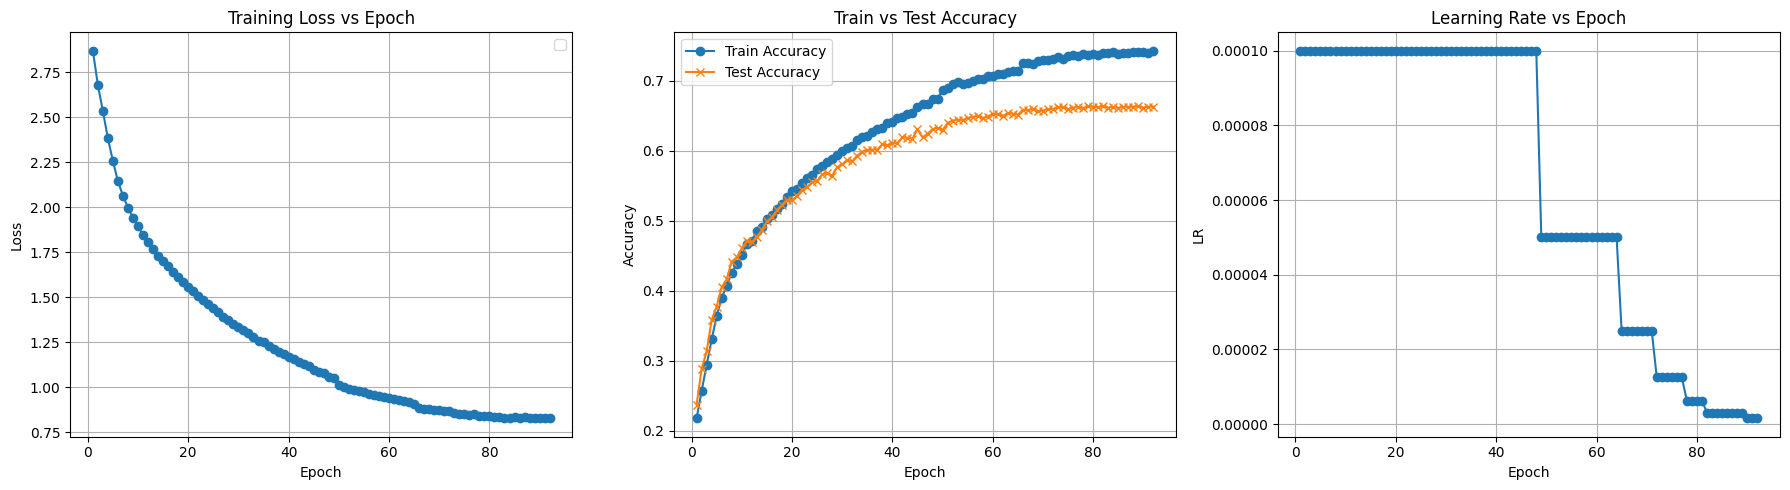

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(18, 5))

# Loss Curve
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, marker = 'o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.legend()
plt.grid()

# Accuracy Curve
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Test Accuracy', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid()

# Learning Rate Curve
plt.subplot(1, 3, 3)
plt.plot(epochs_range, learning_rates, label='Learning Rate', marker='o')
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate vs Epoch")
plt.grid()

plt.tight_layout()
plt.savefig("logs/Devansh_training_curves.png")
plt.show()

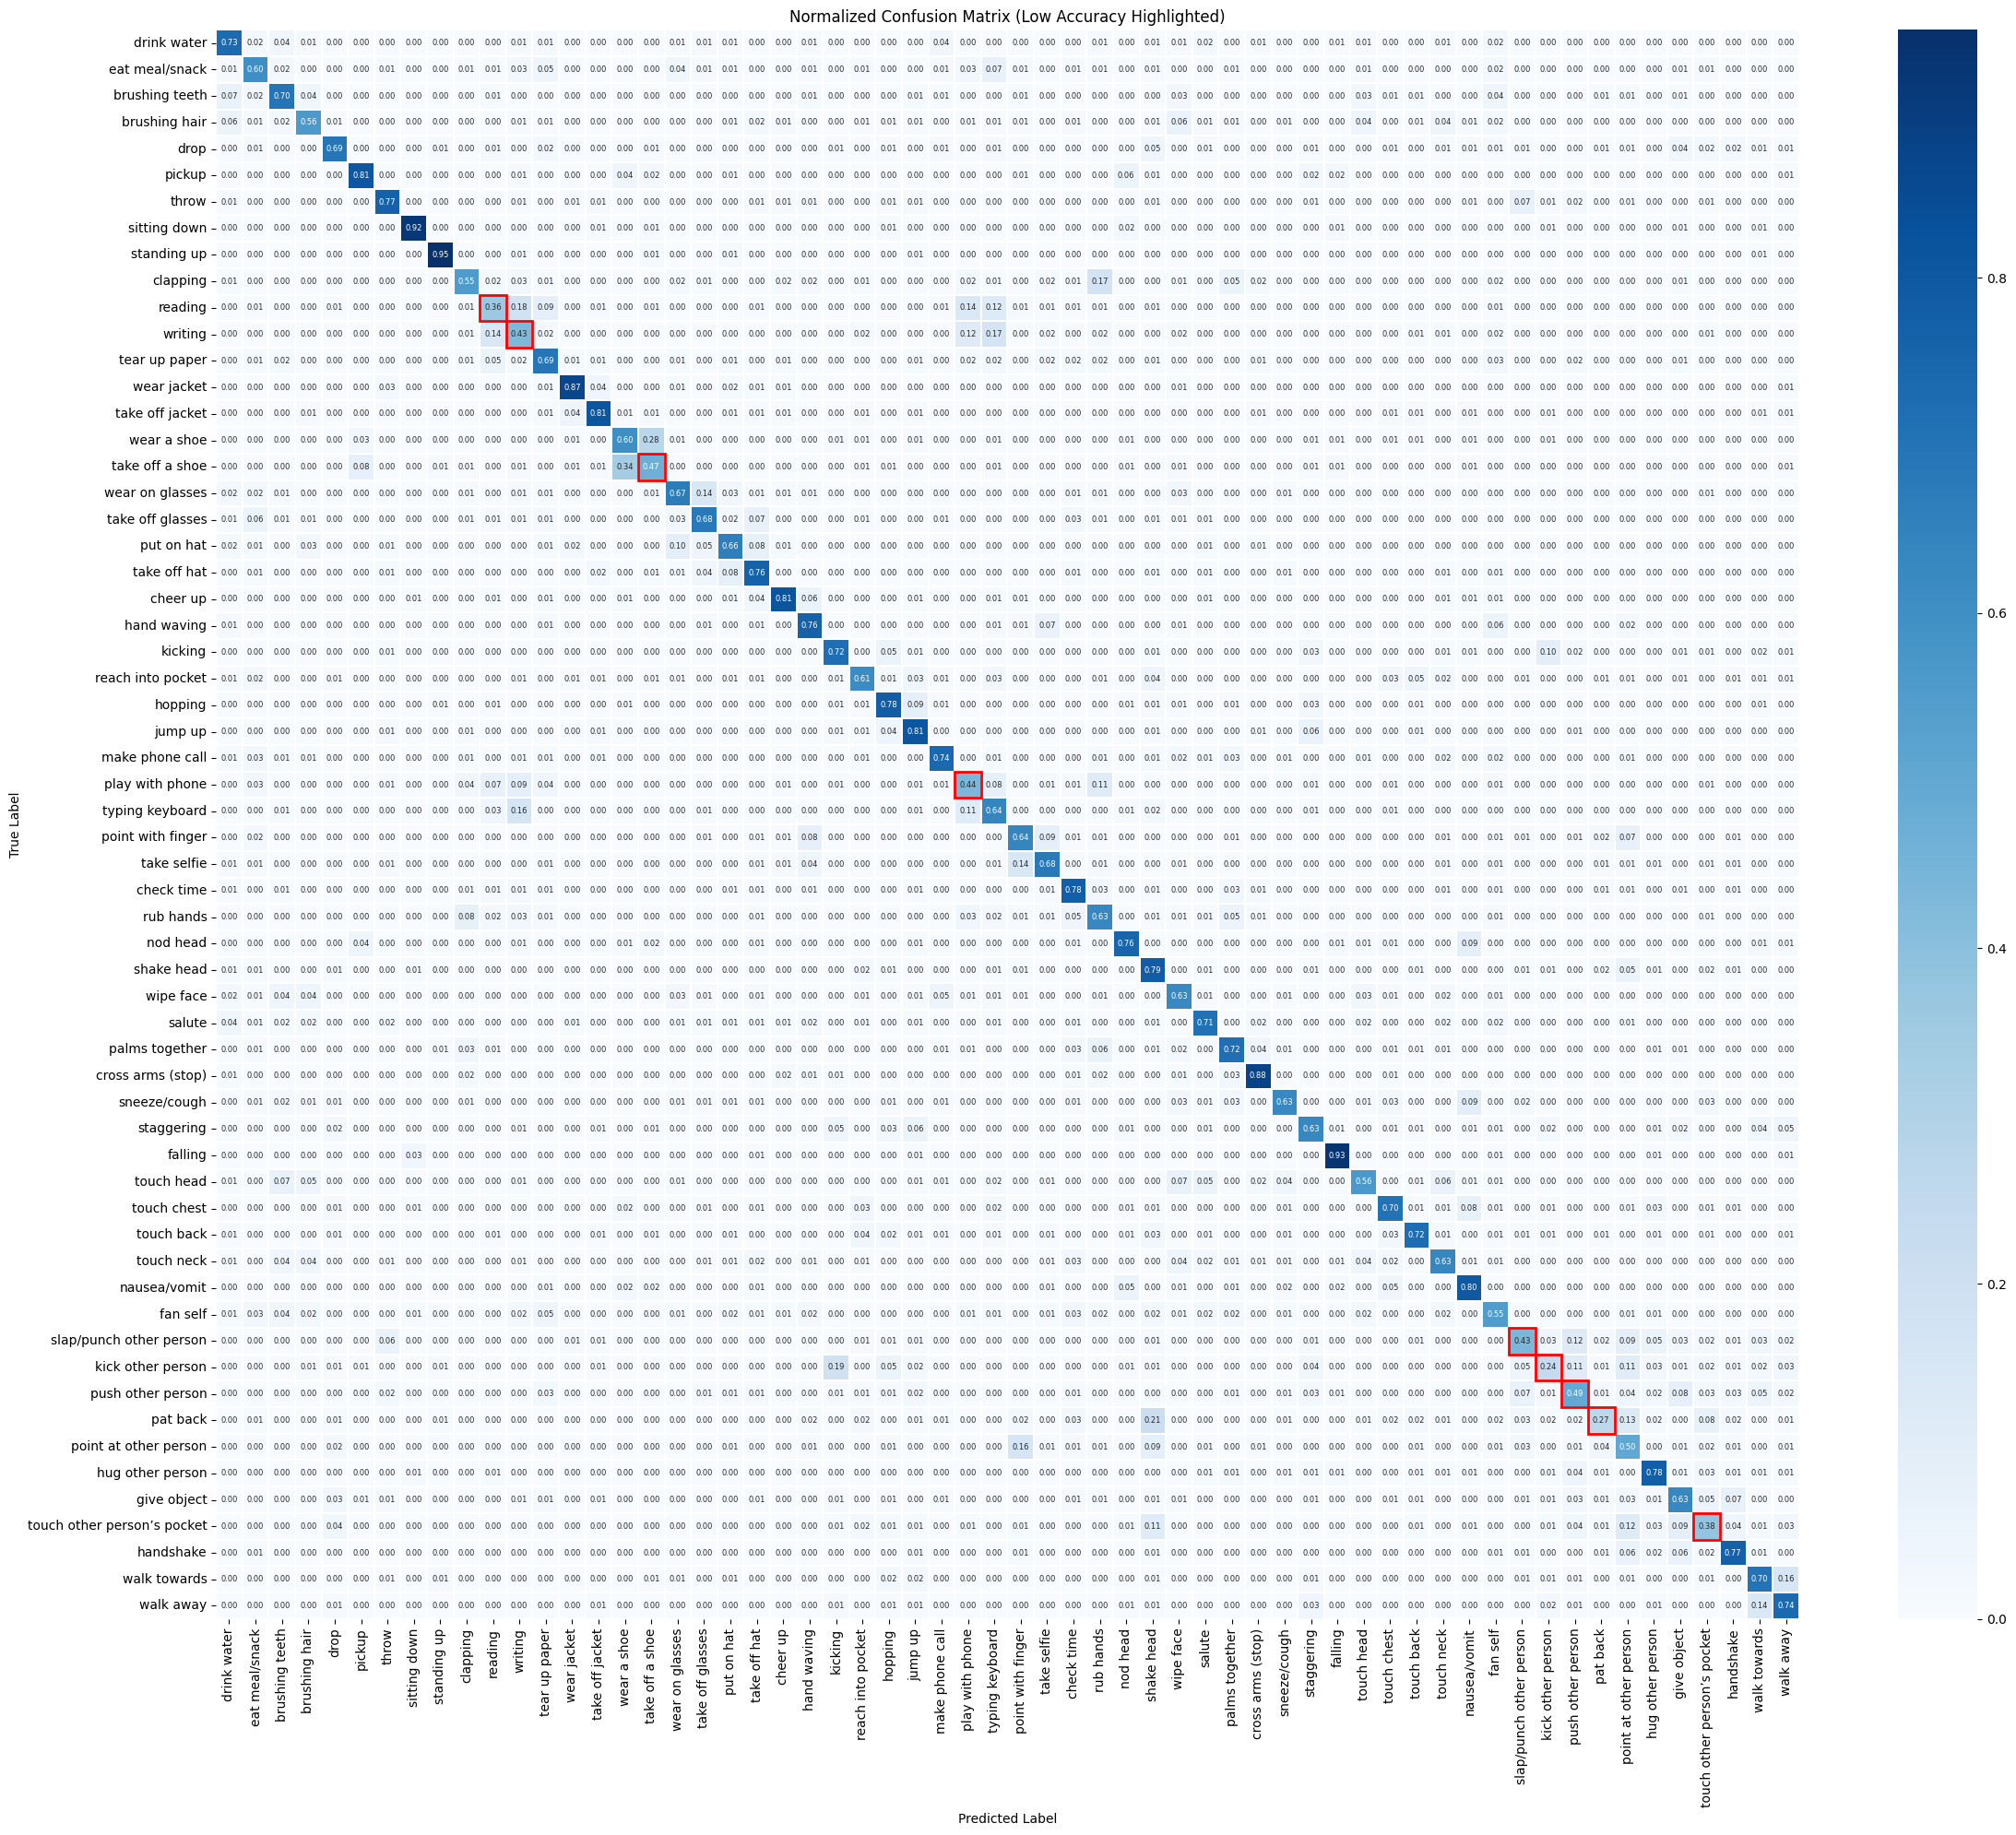


Per-Class Recall (%):
drink water: 72.97%
eat meal/snack: 60.13%
brushing teeth: 69.63%
brushing hair: 55.94%
drop: 69.28%
pickup: 80.69%
throw: 76.60%
sitting down: 91.91%
standing up: 94.78%
clapping: 55.30%
reading: 36.03%
writing: 42.74%
tear up paper: 69.47%
wear jacket: 86.55%
take off jacket: 80.88%
wear a shoe: 60.00%
take off a shoe: 46.88%
wear on glasses: 67.11%
take off glasses: 68.35%
put on hat: 65.91%
take off hat: 76.30%
cheer up: 81.20%
hand waving: 76.47%
kicking: 71.97%
reach into pocket: 61.22%
hopping: 78.32%
jump up: 80.95%
make phone call: 74.07%
play with phone: 43.66%
typing keyboard: 63.76%
point with finger: 63.82%
take selfie: 68.28%
check time: 77.54%
rub hands: 63.01%
nod head: 75.52%
shake head: 78.79%
wipe face: 62.77%
salute: 70.87%
palms together: 71.53%
cross arms (stop): 87.88%
sneeze/cough: 62.84%
staggering: 62.99%
falling: 93.10%
touch head: 56.39%
touch chest: 70.34%
touch back: 72.33%
touch neck: 63.38%
nausea/vomit: 79.70%
fan self: 54.96%
sla

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ NTU60 gesture labels (A001 to A060)
gesture_names = [
    "drink water", "eat meal/snack", "brushing teeth", "brushing hair", "drop",
    "pickup", "throw", "sitting down", "standing up", "clapping",
    "reading", "writing", "tear up paper", "wear jacket", "take off jacket",
    "wear a shoe", "take off a shoe", "wear on glasses", "take off glasses", "put on hat",
    "take off hat", "cheer up", "hand waving", "kicking", "reach into pocket",
    "hopping", "jump up", "make phone call", "play with phone", "typing keyboard",
    "point with finger", "take selfie", "check time", "rub hands", "nod head",
    "shake head", "wipe face", "salute", "palms together", "cross arms (stop)",
    "sneeze/cough", "staggering", "falling", "touch head", "touch chest",
    "touch back", "touch neck", "nausea/vomit", "fan self", "slap/punch other person",
    "kick other person", "push other person", "pat back", "point at other person",
    "hug other person", "give object", "touch other person’s pocket", "handshake",
    "walk towards", "walk away"
]

import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, # Keep this
    # ConfusionMatrixDisplay, # Not needed for Seaborn plot
    classification_report,
    accuracy_score
)
import seaborn as sns # Add seaborn
import numpy as np   # Add numpy

def get_all_preds_and_labels(model, data_loader):
    """Gets predictions and true labels for a dataset."""
    model.eval()
    all_preds_list = []
    all_labels_list = []
    device = next(model.parameters()).device # Get device model is on
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Ensure data is on the correct device
            # Assuming your dataloader provides tensors directly
            # If it provides dicts like {'joint': ..., 'bone': ..., 'label': ...},
            # adjust this part accordingly.
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds_list.extend(preds.cpu().numpy())
            all_labels_list.extend(labels.cpu().numpy())
    return np.array(all_preds_list), np.array(all_labels_list)

# 1. Get Predictions and Labels (using your function)
# Using names from the second block for clarity
all_preds, all_labels = get_all_preds_and_labels(model, val_loader)

# 2. Ensure gesture_names length matches the number of classes found
# (Important if gesture_names is predefined and might be longer)
unique_labels = np.unique(all_labels)
num_classes = len(unique_labels)

# Make sure gesture_names exists and has the right length
if 'gesture_names' not in locals() or gesture_names is None:
    # Create generic names if not provided
    gesture_names = [f"Class {i}" for i in range(num_classes)]
    print(f"Warning: 'gesture_names' not provided. Using generic names: {gesture_names}")
elif len(gesture_names) < num_classes:
     raise ValueError(f"gesture_names has {len(gesture_names)} elements, but {num_classes} classes were found.")
elif len(gesture_names) > num_classes:
     print(f"Warning: gesture_names has {len(gesture_names)} elements, but only {num_classes} unique classes were found in labels. Trimming gesture_names.")
     gesture_names = gesture_names[:num_classes]


# 3. Calculate Confusion Matrices (normalized and raw)
cm = confusion_matrix(all_labels, all_preds, normalize='true', labels=unique_labels) # Use unique_labels to ensure order if some classes are missing
# raw_cm = confusion_matrix(all_labels, all_preds, labels=unique_labels) # Optional: for counts if needed elsewhere

# 4. Calculate Per-class accuracy
# Diagonal of the normalized confusion matrix represents recall for each class
class_acc = np.diag(cm) * 100 # Renamed to  for clarity

# --- [Previous code: imports, function, get predictions/labels, calculate cm] ---

# 5. Plot Confusion Matrix - ADJUSTED FOR SIZE
plt.figure(figsize=(24, 20))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues',
                 xticklabels=gesture_names, yticklabels=gesture_names,
                 annot_kws={"size": 6}, linewidths=0.3, cbar=True)

# 6. Highlight low-accuracy (low-recall) cells
low_acc_threshold = 50  # percent
for i in range(num_classes):
    acc = cm[i, i] * 100
    if acc < low_acc_threshold:
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', linewidth=2))

plt.title(f"Normalized Confusion Matrix (Low Accuracy Highlighted)") # Slightly larger title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# You might want to save this large figure instead of just showing it inline
# plt.savefig("large_confusion_matrix.png", dpi=150)
plt.show()

# --- [Optional: Print per-class recall etc.] ---

# 7. Optional: Print per-class recall (accuracy)
print("\nPer-Class Recall (%):")
for i, name in enumerate(gesture_names):
    print(f"{name}: {class_acc[i]:.2f}%")

print(f"\nOverall Accuracy: {accuracy_score(all_labels, all_preds)*100:.2f}%")

In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.6968    0.7297    0.7129       148
           1     0.6389    0.6013    0.6195       153
           2     0.6573    0.6963    0.6763       135
           3     0.6723    0.5594    0.6107       143
           4     0.7910    0.6928    0.7387       153
           5     0.8182    0.8069    0.8125       145
           6     0.7770    0.7660    0.7714       141
           7     0.9191    0.9191    0.9191       136
           8     0.9338    0.9478    0.9407       134
           9     0.6759    0.5530    0.6083       132
          10     0.4667    0.3603    0.4066       136
          11     0.3487    0.4274    0.3841       124
          12     0.5987    0.6947    0.6431       131
          13     0.8512    0.8655    0.8583       119
          14     0.8148    0.8088    0.8118       136
          15     0.5783    0.6000    0.5890       160
          16     0.5396    0.4688    0.5017       160
    